# Vanilla LSTM for Gene/No gene classification
The Milestone 1 corresponds to the classication task of, given a sequence, predict if it contains a gene, a partial sequence of a gene or just intergenic code.

In [0]:
!pip3 install pyfastx

     |████████████████████████████████| 768kB 2.8MB/s 


In [0]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import pandas as pd

from tqdm import tqdm # progress bar
from preproc_pipeline import window_pipeline
from warnings import simplefilter

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 1. Dataset for training
The genome of E. coli will be used for this purpose.

In [0]:
simplefilter("ignore")
genome = "GCF_000008865.2_ASM886v2_genomic.fna"
feature_table = "GCA_000008865.2_ASM886v2_feature_table.tsv"
df = window_pipeline(genome, feature_table)

In [0]:
print(df.sequence.apply(lambda x: len(x)).max())
len(df)

50


36169

In [0]:
print(
    f"columns -> {list(df.columns)}\n"
    f"labels in dataframe -> {list(df.label.unique())}"
)

columns -> ['sequence', 'label']
labels in dataframe -> ['gene', 'intergenic', 'partial']


Let's get a one hot mapping for the labels.

In [0]:
labels = list(df.label.unique())
lab0 = np.zeros(len(labels))
lab2vec = {}
vec2lab = {}
for i, label in enumerate(list(df.label.unique())):
    labv = lab0.copy()
    labv[i] = 1
    lab2vec[label] = labv
    vec2lab[tuple(labv)] = label

print(f"lab2vec -> {lab2vec}\nvec2lab -> {vec2lab}")

lab2vec -> {'gene': array([1., 0., 0.]), 'intergenic': array([0., 1., 0.]), 'partial': array([0., 0., 1.])}
vec2lab -> {(1.0, 0.0, 0.0): 'gene', (0.0, 1.0, 0.0): 'intergenic', (0.0, 0.0, 1.0): 'partial'}


In [0]:
print(df[df.sequence.apply(lambda x: len(x)==0)].count())
df = df[~df.sequence.apply(lambda x: len(x)==0)]

sequence    0
label       0
dtype: int64


Need to check why it always generate a 0 length row. I think is the last one, but I am not sure.

In [0]:
df["label_onehot"] = df.label.apply(lambda x: lab2vec[x])
toy = pd.concat([df[df.label=="gene"].sample(n=5000),
                df[df.label=="intergenic"].sample(n=5000)])
                # df[df.label=="partial"].sample(n=100)]).reset_index(drop=True)
toy["label_onehot"] = toy.label_onehot.apply(lambda x: x[0:2])
df_train = toy.sample(frac=8/10) # separate training from testing
df_test = toy[~toy.sequence.isin(df_train.sequence)].reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_train

,sequence,label,label_onehot
0,TGGTCAAATCTCAACCGATTTTGAGATATATCTTGCGCGGGATCCC...,gene,"[1.0, 0.0]"
1,GTCCATTTCTCTTGAGATAACATTTTAATTGCTACGGATTATGGCT...,intergenic,"[0.0, 1.0]"
2,AGTTGTCCATGATTGTCCATAGACAACTGTAAATGTTCAGGTGCGC...,intergenic,"[0.0, 1.0]"
3,CAATATAGAGATTATATATGAACAGGAGGAATAGCTGCTTTTAAAG...,intergenic,"[0.0, 1.0]"
4,TGTCTTTATATATAAAACTCATCCTCTCAATTGTCAGGGAAATTAG...,gene,"[1.0, 0.0]"
...,...,...,...
7995,TGACAAATGCCGGGTAACAATCCGGCATTCAGCGCCTGATGCGACG...,intergenic,"[0.0, 1.0]"
7996,AGAAATCCTTTCTTAGAGAATTATTGAGGTCCGGTATCATACCGAT...,intergenic,"[0.0, 1.0]"
7997,TATTTAACGCGCGAGAAAAGTACCATCGATTCCAGATGTCCCGTGT...,gene,"[1.0, 0.0]"
7998,CAAGCTGCCGCCCTAGTGTAGAAGCAGCGTTACTAATTCCATTAAG...,gene,"[1.0, 0.0]"


In [0]:
df_test = df_test.sample(frac=1).reset_index(drop=True) # shuffle
df_test

,sequence,label,label_onehot
0,GCAAAGCAGGCGCTCTCCCAGCTGAGCTATAGCCCCATAACATGTA...,intergenic,"[0.0, 1.0]"
1,TTACATTATCATAATGATAAGTTAACATAGTCTGAACATACGGCAC...,intergenic,"[0.0, 1.0]"
2,ACAGTGAAATAAACCACTTTGCCTGTCATTCCACTACCGGGACTTT...,intergenic,"[0.0, 1.0]"
3,CATGATGCACTCCCGACTGGCGTTTTCAGCCCGGAATAGTTCAACA...,gene,"[1.0, 0.0]"
4,GCAGGTTAACAGGCCACAAATCAGAACCGGAACGGTCACCGGCGAC...,gene,"[1.0, 0.0]"
...,...,...,...
1933,TCATATTTGCCGGCTGGATACGGCGGGCGCACGAGTACTGGAAAAC...,gene,"[1.0, 0.0]"
1934,TTATCCCCTCTTTTGTAGATTGCCCGATGCGACGCTAAAGCGTCAT...,intergenic,"[0.0, 1.0]"
1935,CAGGCGTTGATAATTTGATTAATTTCGTTGGCGCTCAAATGGTACT...,gene,"[1.0, 0.0]"
1936,TCTGGCATTTGCACTGAATGCCAGATGCGGCGTAAACGCCTTATCC...,intergenic,"[0.0, 1.0]"


## 2. Embeddings
The next step is to use the whole sequence to compute the embeddings. First, get a set of k-mers, that will be our words for this NLP problem.

Finally, gather all the kmers and apply the CBOW algorithm.

In [0]:
# Since we have the embeddings stored, we are going to ignore the following next
# two cells and use this one
stored = False

if stored:
  with open("/content/drive/My Drive/wti.p", "rb") as f:
    word_to_ix = pickle.load(f)
  ix_to_word = {v: k for k,v in word_to_ix.items()}
  model_save_name = 'ma_model.pt'
  path = model_save_name
  path = F"/content/drive/My Drive/{model_save_name}" 
  model = CBOW(len(word_to_ix), EMDEDDING_DIM, padding_idx=word_to_ix["X"]).cpu()
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

## 4. Vanilla RNN model

In [0]:
from torch.autograd import Variable


def compute_conv_dim(dim_size, kernel, padding, stride):
    return int((dim_size + 2 * padding - (kernel-1) - 1) / stride + 1)


class convLSTM(nn.Module):
    def __init__(self, t, input_dim=1, hidden_dim=34, hidden_out=90, 
        output_dim=2, out_channels=1, kernel_size=8, stride=2, padding=0,
        bidirectional=True):

        super().__init__()
        self.nb_tags = output_dim

        self.conv = nn.Conv1d(input_dim, out_channels, kernel_size, 
                              stride, padding=padding, bias = False)
        
        # compute output dimension of Convnet as input t of LSTM
        len_to_lstm = (
            out_channels *
            compute_conv_dim(t, kernel_size, padding, stride) 
        )
        directions = 2 if bidirectional else 1

        self.rnn = nn.LSTM(input_dim, hidden_dim, bidirectional=bidirectional, 
                           batch_first=True)
        
        self.fnn2 = nn.Sequential(
            nn.Linear(len_to_lstm*hidden_dim*directions, hidden_out),
            nn.BatchNorm1d(hidden_out), 
            nn.ReLU(),
            # nn.AlphaDropout(),
            nn.Linear(hidden_out, output_dim)
        )


    def forward(self, text):
        
        text = text.permute(0,2,1)
        output = self.conv(text)
        #print(output.data.size())


        output = output.permute(0,2,1)
        
        # 1. LSTM
        output, hidden = self.rnn(output)

        # 2. get that so it's correctly packed for the hidden layer
        output = output.contiguous()
        output = output.reshape(output.shape[0], -1)

        # 3. classification
        output = self.fnn2(output)
        return output

## 4. Tweak the embeddings to accomodate varying sizes of the sequences
Once we have the model and the embeddings, we would need to tweak the embeddings so that they are adjusted for the padded sequences.

### 4.1. Add the padding char to the embeddings

Now, get sequences as indexes.

The following code is to try and entirely different way with enco

In [0]:
def code_one_hot(seq,vocab):
  encoding = np.array([vocab[ch] for ch in seq], dtype="int64")

  encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
  return encoding

nuc_to_ix = {"A": [1,0,0,0], "G": [0,1,0,0], "T": [0,0,1,0], "C" : [0,0,0,1]}
nuc_to_class = {"A": [0], "G": [1], "T": [2], "C" : [3]}

nuc_to_ix = {"A": [1,0,0,0], "G": [0,1,0,0], "T": [0,0,1,0], "C" : [0,0,0,1]}
nuc_to_class = {k: np.array(v, "int64") for k,v in nuc_to_class.items()}

In [0]:
df_train["onehot"] = df_train.sequence.apply(lambda x: code_one_hot(x, nuc_to_ix))
df_test["onehot"] = df_test.sequence.apply(lambda x: code_one_hot(x, nuc_to_ix))

df_train["c_class"] = df_train.sequence.apply(lambda x: code_one_hot(x, nuc_to_class))
df_test["c_class"] = df_test.sequence.apply(lambda x: code_one_hot(x, nuc_to_class))

df_train

,sequence,label,label_onehot,onehot,c_class
0,TGGTCAAATCTCAACCGATTTTGAGATATATCTTGCGCGGGATCCC...,gene,"[1.0, 0.0]","[[0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...","[[2], [1], [1], [2], [3], [0], [0], [0], [2], ..."
1,GTCCATTTCTCTTGAGATAACATTTTAATTGCTACGGATTATGGCT...,intergenic,"[0.0, 1.0]","[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[[1], [2], [3], [3], [0], [2], [2], [2], [3], ..."
2,AGTTGTCCATGATTGTCCATAGACAACTGTAAATGTTCAGGTGCGC...,intergenic,"[0.0, 1.0]","[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0,...","[[0], [1], [2], [2], [1], [2], [3], [3], [0], ..."
3,CAATATAGAGATTATATATGAACAGGAGGAATAGCTGCTTTTAAAG...,intergenic,"[0.0, 1.0]","[[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0,...","[[3], [0], [0], [2], [0], [2], [0], [1], [0], ..."
4,TGTCTTTATATATAAAACTCATCCTCTCAATTGTCAGGGAAATTAG...,gene,"[1.0, 0.0]","[[0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0,...","[[2], [1], [2], [3], [2], [2], [2], [0], [2], ..."
...,...,...,...,...,...
7995,TGACAAATGCCGGGTAACAATCCGGCATTCAGCGCCTGATGCGACG...,intergenic,"[0.0, 1.0]","[[0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...","[[2], [1], [0], [3], [0], [0], [0], [2], [1], ..."
7996,AGAAATCCTTTCTTAGAGAATTATTGAGGTCCGGTATCATACCGAT...,intergenic,"[0.0, 1.0]","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1,...","[[0], [1], [0], [0], [0], [2], [3], [3], [2], ..."
7997,TATTTAACGCGCGAGAAAAGTACCATCGATTCCAGATGTCCCGTGT...,gene,"[1.0, 0.0]","[[0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0,...","[[2], [0], [2], [2], [2], [0], [0], [3], [1], ..."
7998,CAAGCTGCCGCCCTAGTGTAGAAGCAGCGTTACTAATTCCATTAAG...,gene,"[1.0, 0.0]","[[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0,...","[[3], [0], [0], [1], [3], [2], [1], [3], [3], ..."


In [0]:
print(f"number of rows -> {len(df_train)}")
print(f"length of index seq -> {np.unique(df_train.c_class.apply(lambda x: len(x)))}")

number of rows -> 8000
length of index seq -> [50]


Finally, instantiante the model.

In [0]:
t = len(df_train.iloc[0,-1]) # Find length of seqs (fixed)

rnn = convLSTM(input_dim=1, hidden_dim = 34, hidden_out = 90, output_dim=2, t = t).cuda()

optimizer = torch.optim.ASGD(rnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().cuda()

## 5. Training loop


All that is left is to split our training and testing and train the model.

In [0]:
from torch.utils.data import DataLoader, Dataset

class oversampdata(Dataset):
  def __init__(self, data):
    # first column is list of index sentence
    self.data = torch.LongTensor(np.ndarray.astype(np.array([
                    np.array(r) 
                    for r in data.iloc[:,0].to_numpy()]), "int64"))
    # second column is the labels
    self.targets = torch.LongTensor(np.ndarray.astype(np.array([
                    np.array(r) 
                    for r in data.iloc[:,1].to_numpy()]), "int64"))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data_val = self.data[index]
    target = self.targets[index]
    return data_val, target

train_dataset = oversampdata(df_train.loc[:,["c_class", "label_onehot"]])
valid_dataset = oversampdata(df_test.loc[:,["c_class", "label_onehot"]])

In [0]:
BATCH_SIZE = 30

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                          shuffle=True, drop_last = False)
testloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, 
                                         shuffle=True, drop_last = False)

In [0]:
def binary_accuracy(preds, y):
   """
   Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
   """
   rounded_preds = torch.zeros(preds.size())
   for i in range(len(preds)):
     idx_max = torch.where(preds[i] == preds[i].max())
     rounded_preds[i][idx_max] = 1
   rounded_preds = torch.FloatTensor(rounded_preds).int()
   correct = (rounded_preds == y).float() #convert into float for division
   acc = (correct.sum()/len(preds[0])) / len(correct)
   return acc

In [0]:
from torch.nn import Parameter
import matplotlib.pyplot as plt
import sys
# Colab in dark mode, guys :)
plt.style.use(['seaborn-dark', 'dark_background'])

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    print("Training...")

    for i, batch in enumerate(iterator):
        if not i%10:
          sys.stdout.write(f"\rIteration {i}        ")
          sys.stdout.flush()

        inputs, labels_onehot = batch

        inputs = Parameter(inputs.float(), requires_grad=True).cuda()

        predictions = model(inputs)
        
        labels_idx = torch.LongTensor([np.where(label==1)[0][0] for label in labels_onehot]).cuda()
        loss = criterion(predictions, labels_idx)

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        acc = binary_accuracy(predictions, labels_onehot)
        # print(loss.item())
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    print("Evaluating...")

    for i, batch in enumerate(iterator):

        inputs, labels_onehot = batch
        
        inputs = Parameter(inputs.float(), requires_grad=False).cuda()

        predictions = model(inputs)
        labels_idx = torch.LongTensor([np.where(label==1)[0][0] for label in labels_onehot]).cuda()

        loss = criterion(predictions, labels_idx)
        acc = binary_accuracy(predictions, labels_onehot)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def plot_network(epochs, train_loss, test_loss):
    """ Neon """
    plt.figure()
    # Other Neon colors of the palette -> #13CA91 #3B27BA #E847AE #FF9472
    plt.plot(epochs, train_loss, color='#13CA91', marker = "o", linestyle='-', label='Training loss',)
    plt.plot(epochs, test_loss, color='#3B27BA', marker = "o", linestyle='-', label='Validation loss')
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('NLL')
    plt.show()

In [0]:
len(train_dataset)

8000

Epoch: 0
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.685 | Train Acc: 55.28%
	 Val. Loss: 0.666 |  Val. Acc: 59.62%
Epoch: 1
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.665 | Train Acc: 59.48%
	 Val. Loss: 0.663 |  Val. Acc: 59.44%
Epoch: 2
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.659 | Train Acc: 60.52%
	 Val. Loss: 0.664 |  Val. Acc: 60.91%
Epoch: 3
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.656 | Train Acc: 61.15%
	 Val. Loss: 0.653 |  Val. Acc: 62.46%
Epoch: 4
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.651 | Train Acc: 61.69%
	 Val. Loss: 0.650 |  Val. Acc: 63.21%
Epoch: 5
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.648 | Train Acc: 62.11%
	 Val. Loss: 0.648 |  Val. Acc: 63.35%
Epoch: 6
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.645 | Train Acc: 62.36%
	 Val. Loss: 0.646 |  Val. Acc: 63.88%
Epoch: 7
Training...
Iteration 260        
Evaluating..

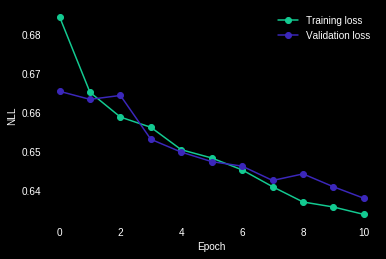

Epoch: 11
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.630 | Train Acc: 63.97%
	 Val. Loss: 0.635 |  Val. Acc: 64.70%
Epoch: 12
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.628 | Train Acc: 64.45%
	 Val. Loss: 0.636 |  Val. Acc: 63.73%
Epoch: 13
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.625 | Train Acc: 64.36%
	 Val. Loss: 0.631 |  Val. Acc: 64.99%
Epoch: 14
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.627 | Train Acc: 64.60%
	 Val. Loss: 0.639 |  Val. Acc: 62.70%
Epoch: 15
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.623 | Train Acc: 64.76%
	 Val. Loss: 0.631 |  Val. Acc: 64.97%
Epoch: 16
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.621 | Train Acc: 65.12%
	 Val. Loss: 0.630 |  Val. Acc: 64.99%
Epoch: 17
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.618 | Train Acc: 65.34%
	 Val. Loss: 0.626 |  Val. Acc: 64.75%
Epoch: 18
Training...
Iteration 260        
Eval

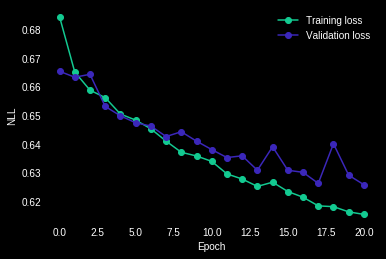

Epoch: 21
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.614 | Train Acc: 66.04%
	 Val. Loss: 0.625 |  Val. Acc: 63.97%
Epoch: 22
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.612 | Train Acc: 66.00%
	 Val. Loss: 0.626 |  Val. Acc: 63.64%
Epoch: 23
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.612 | Train Acc: 65.69%
	 Val. Loss: 0.622 |  Val. Acc: 64.84%
Epoch: 24
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.610 | Train Acc: 66.06%
	 Val. Loss: 0.624 |  Val. Acc: 65.08%
Epoch: 25
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.609 | Train Acc: 66.31%
	 Val. Loss: 0.624 |  Val. Acc: 64.96%
Epoch: 26
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.610 | Train Acc: 66.52%
	 Val. Loss: 0.644 |  Val. Acc: 62.87%
Epoch: 27
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.608 | Train Acc: 66.23%
	 Val. Loss: 0.621 |  Val. Acc: 63.90%
Epoch: 28
Training...
Iteration 260        
Eval

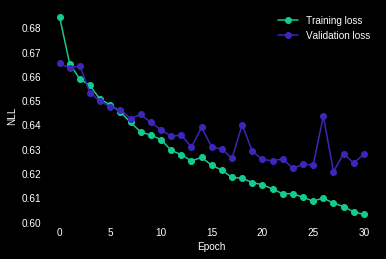

Epoch: 31
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.601 | Train Acc: 67.48%
	 Val. Loss: 0.619 |  Val. Acc: 64.50%
Epoch: 32
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.601 | Train Acc: 66.80%
	 Val. Loss: 0.645 |  Val. Acc: 63.32%
Epoch: 33
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.602 | Train Acc: 67.02%
	 Val. Loss: 0.629 |  Val. Acc: 64.03%
Epoch: 34
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.600 | Train Acc: 67.44%
	 Val. Loss: 0.636 |  Val. Acc: 64.58%
Epoch: 35
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.598 | Train Acc: 67.85%
	 Val. Loss: 0.617 |  Val. Acc: 64.55%
Epoch: 36
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.599 | Train Acc: 67.09%
	 Val. Loss: 0.632 |  Val. Acc: 63.09%
Epoch: 37
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.597 | Train Acc: 67.39%
	 Val. Loss: 0.619 |  Val. Acc: 63.61%
Epoch: 38
Training...
Iteration 260        
Eval

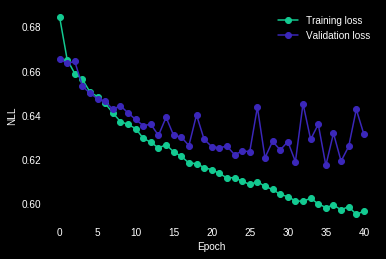

Epoch: 41
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.594 | Train Acc: 67.39%
	 Val. Loss: 0.628 |  Val. Acc: 64.60%
Epoch: 42
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.594 | Train Acc: 68.06%
	 Val. Loss: 0.618 |  Val. Acc: 64.43%
Epoch: 43
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.594 | Train Acc: 67.98%
	 Val. Loss: 0.616 |  Val. Acc: 65.32%
Epoch: 44
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.595 | Train Acc: 68.01%
	 Val. Loss: 0.626 |  Val. Acc: 64.07%
Epoch: 45
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.592 | Train Acc: 68.03%
	 Val. Loss: 0.618 |  Val. Acc: 65.30%
Epoch: 46
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.591 | Train Acc: 67.67%
	 Val. Loss: 0.616 |  Val. Acc: 65.18%
Epoch: 47
Training...
Iteration 260        
Evaluating...
	Train Loss: 0.590 | Train Acc: 68.25%
	 Val. Loss: 0.627 |  Val. Acc: 64.55%
Epoch: 48
Training...
Iteration 260        
Eval

In [0]:
N_EPOCHS = 50
model_save_name="ma_rnn.pt"
path = F"/content/drive/My Drive/{model_save_name}"

all_train_loss = []
all_val_loss = []
all_epochs = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    print("Epoch: " + str(epoch))
    train_loss, train_acc = train(rnn, trainloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(rnn, testloader, criterion)

    #train_loss  = train(rnn, trainloader, optimizer, criterion)
    #valid_loss  = evaluate(rnn, testloader, criterion)    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(rnn.state_dict(), path)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    all_train_loss.append(train_loss)
    all_val_loss.append(valid_loss)
    all_epochs.append(epoch)

    if not epoch%10 and epoch != 0:
      plot_network(all_epochs, all_train_loss, all_val_loss)

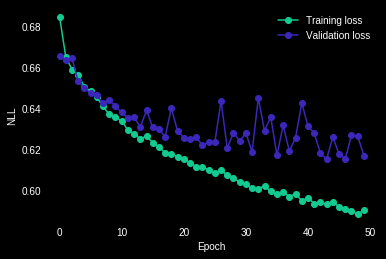

In [0]:
plot_network(all_epochs, all_train_loss, all_val_loss) # just batchnorm

In [0]:
model_save_name="ma_.pt"
path = F"/content/drive/My Drive/{model_save_name}"
torch.save(rnn.state_dict(), path)